### Cargar datos de entrenamiento y de prueba, e importar librerías

In [0]:
# Importar librerías
from pyspark.ml.feature import VectorAssembler
from pyspark.ml import Pipeline, PipelineModel
from pyspark.ml.classification import GBTClassifier
from pyspark.ml.evaluation import BinaryClassificationEvaluator
from pyspark.ml.tuning import ParamGridBuilder, CrossValidator, CrossValidatorModel
from pyspark.sql.functions import udf, col, when
from pyspark.sql.types import DoubleType
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from sklearn.metrics import roc_curve, roc_auc_score

In [0]:
# Cargar archivos desde DBFS
test_df = spark.read.parquet("dbfs:/tmp/wiki_data/test_df_final.parquet")
train_df = spark.read.parquet("dbfs:/tmp/wiki_data/train_df_final.parquet")

### Vectorizar características y crear clasificador Gradient Boosting Trees 

In [0]:
# Guardar la columna Customer_ID en variables separadas
train_customer_id = train_df.select("Customer_ID", "target")
train_df2 = train_df
train_df = train_df.drop("Customer_ID")

# Identificar las columnas de características
feature_columns = [col for col in train_df.columns if col not in ['Customer_ID', 'target']]
assembler = VectorAssembler(inputCols=feature_columns, outputCol='features')

In [0]:
# Crear el clasificador GBT
gbt = GBTClassifier(featuresCol='features', labelCol='target')

# Crear el pipeline
pipeline = Pipeline(stages=[assembler, gbt])

### Configurar la búsqueda de hiperparámetros con Validación Cruzada

In [0]:
# Construir la cuadrícula de hiperparámetros
paramGrid = (ParamGridBuilder()
              .addGrid(gbt.maxIter, [10, 20])
              .addGrid(gbt.maxDepth, [5, 7])
              .addGrid(gbt.stepSize, [0.1])
              .addGrid(gbt.subsamplingRate, [1.0])
              .build())

# Configurar el evaluador
evaluator = BinaryClassificationEvaluator(labelCol='target', metricName='areaUnderROC')

# Configurar la validación cruzada
crossval = CrossValidator(estimator=pipeline,
                          estimatorParamMaps=paramGrid,
                          evaluator=evaluator,
                          numFolds=4) 

### Entrenar los modelos y seleccionar el mejor de ellos

In [0]:
# Ajustar el modelo con la validación cruzada
cv_model = crossval.fit(train_df)

In [0]:
# Seleccionar el mejor modelo de los entrenados
best_model = cv_model.bestModel

In [0]:
# Eliminar el directorio existente
dbutils.fs.rm("dbfs:/tmp/wiki_data/gbt_model", recurse=True)

# Guardar el nuevo modelo
best_model.save("dbfs:/tmp/wiki_data/gbt_model")

### Realizar inferencia con el modelo entrenado

In [0]:
# Cargar el modelo guardado en DBFS
cv_model = PipelineModel.load("dbfs:/tmp/wiki_data/gbt_model")

In [0]:
# Preparar el DataFrame de prueba
test_df = test_df.withColumnRenamed('Customer_ID', 'customer_id')

# Definir la función UDF para extraer la probabilidad de la clase positiva
def extract_probability(prob_vector):
    return float(prob_vector[1])

# Registrar la UDF
extract_prob_udf = udf(extract_probability, DoubleType())

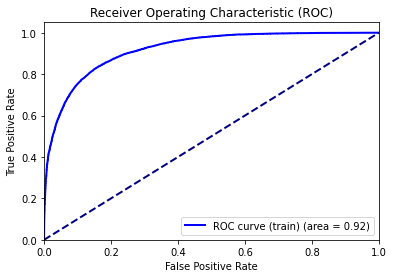

In [0]:
# Obtener las predicciones del conjunto de entrenamiento
predictions_train = cv_model.transform(train_df)
predictions_train = predictions_train.withColumn('probability_score', extract_prob_udf(predictions_train['probability']))

# Obtener las predicciones del conjunto de prueba
predictions_test = cv_model.transform(test_df)
predictions_test = predictions_test.withColumn('probability_score', extract_prob_udf(predictions_test['probability']))

# Seleccionar las columnas necesarias para la curva ROC en el conjunto de entrenamiento
result_train = predictions_train.select('probability_score', 'target')

# Convertir a Pandas DataFrame para el conjunto de entrenamiento
pdf_train = result_train.toPandas()

# Calcular la curva ROC para el conjunto de entrenamiento
fpr_train, tpr_train, _ = roc_curve(pdf_train['target'], pdf_train['probability_score'])
roc_auc_train = roc_auc_score(pdf_train['target'], pdf_train['probability_score'])

# Graficar la curva ROC para el conjunto de entrenamiento
plt.figure()
plt.plot(fpr_train, tpr_train, color='blue', lw=2, label=f'ROC curve (train) (area = {roc_auc_train:.2f})')
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC)')
plt.legend(loc='lower right')
plt.show()

### Evaluación bajo métricas clásicas

In [0]:
# DF predictions_train2 debe contener la columna con las etiquetas
predictions_train2 = cv_model.transform(train_df2)
predictions_train2 = predictions_train2.withColumn('probability_score', extract_prob_udf(predictions_train2['probability']))
evaluator = BinaryClassificationEvaluator(labelCol="target", rawPredictionCol="probability_score", metricName="areaUnderROC")
roc_auc = evaluator.evaluate(predictions_train2)
def extract_prob(v):
    if isinstance(v, list) and len(v) > 1:
        return float(v[1])
    else:
        return float(v)

extract_prob_udf = udf(extract_prob, DoubleType())
predictions = predictions_train2.withColumn("probability_score", extract_prob_udf(col("probability_score")))
threshold = 0.5

predictions = predictions.withColumn(
    "prediction_binary",
    when(col("probability_score") > threshold, 1).otherwise(0))

# Contar Verdaderos Positivos, Verdaderos Negativos, Falsos Positivos, Falsos Negativos
tp = predictions.filter((col("prediction_binary") == 1) & (col("target") == 1)).count()
tn = predictions.filter((col("prediction_binary") == 0) & (col("target") == 0)).count()
fp = predictions.filter((col("prediction_binary") == 1) & (col("target") == 0)).count()
fn = predictions.filter((col("prediction_binary") == 0) & (col("target") == 1)).count()

# Calcular métricas
precision = tp / (tp + fp) if (tp + fp) > 0 else 0
recall = tp / (tp + fn) if (tp + fn) > 0 else 0
f1_score = 2 * (precision * recall) / (precision + recall) if (precision + recall) > 0 else 0

print(f"Precision: {precision}")
print(f"Recall: {recall}")
print(f"F1 Score: {f1_score}")
print(f"ROC AUC: {roc_auc}")

Precision: 0.8343840429929723
Recall: 0.8894458521537953
F1 Score: 0.8610355676425105
ROC AUC: 0.9193515540469456


### Evaluación bajo la métrica solicitada

In [0]:
# Métrica de evaluación
def amex_metric(y_true: pd.DataFrame, y_pred: pd.DataFrame) -> float:

    def top_four_percent_captured(y_true: pd.DataFrame, y_pred: pd.DataFrame) -> float:
        df = (pd.concat([y_true, y_pred], axis='columns')
              .sort_values('prediction', ascending=False))
        df['weight'] = df['target'].apply(lambda x: 20 if x==0 else 1)
        four_pct_cutoff = int(0.04 * df['weight'].sum())
        df['weight_cumsum'] = df['weight'].cumsum()
        df_cutoff = df.loc[df['weight_cumsum'] <= four_pct_cutoff]
        return (df_cutoff['target'] == 1).sum() / (df['target'] == 1).sum()
        
    def weighted_gini(y_true: pd.DataFrame, y_pred: pd.DataFrame) -> float:
        df = (pd.concat([y_true, y_pred], axis='columns')
              .sort_values('prediction', ascending=False))
        df['weight'] = df['target'].apply(lambda x: 20 if x==0 else 1)
        df['random'] = (df['weight'] / df['weight'].sum()).cumsum()
        total_pos = (df['target'] * df['weight']).sum()
        df['cum_pos_found'] = (df['target'] * df['weight']).cumsum()
        df['lorentz'] = df['cum_pos_found'] / total_pos
        df['gini'] = (df['lorentz'] - df['random']) * df['weight']
        return df['gini'].sum()

    def normalized_weighted_gini(y_true: pd.DataFrame, y_pred: pd.DataFrame) -> float:
        y_true_pred = y_true.rename(columns={'target': 'prediction'})
        return weighted_gini(y_true, y_pred) / weighted_gini(y_true, y_true_pred)

    g = normalized_weighted_gini(y_true, y_pred)
    d = top_four_percent_captured(y_true, y_pred)

    return 0.5 * (g + d)

In [0]:
from pyspark.sql.functions import udf
from pyspark.sql.types import FloatType
import pandas as pd

# Definir el UDF para extraer la probabilidad de la clase positiva
def extract_prob(probability):
    return float(probability[1])

extract_prob_udf = udf(extract_prob, FloatType())
y_true = train_customer_id.select('Customer_ID', 'target')

# Aplicar el UDF a la columna 'probability' para obtener 'probability_score'
predictions_train2 = cv_model.transform(train_df2)
predictions_train2 = predictions_train2.withColumn('probability_score', extract_prob_udf(predictions_train2['probability']))

# Seleccionar 'Customer_ID' y 'probability_score'
y_pred = predictions_train2.select('Customer_ID', 'probability_score')
y_pred = y_pred.withColumnRenamed("probability_score", "prediction")

# Convertir los DataFrames de PySpark a Pandas
y_true_pd = y_true.toPandas()
y_pred_pd = y_pred.toPandas()

# Calcular y mostrar la métrica
print(f'\nM score: {amex_metric(y_true_pd, y_pred_pd)}')


M score: 0.6322197863444251


In [0]:
# Guardar las predicciones del conjunto de prueba en un archivo CSV
result_test = predictions_test.select('customer_id', 'probability_score')
result_test.write.csv("dbfs:/tmp/wiki_data/inference.csv", header=True, mode='overwrite')